In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# Cargar los datos 
beg_inv = pd.read_csv('BegInv12312016.csv')
end_inv = pd.read_csv('EndInvFINAL12312016.csv')
purchases = pd.read_csv('purchasesFINAL12312016.csv')

In [76]:
# Verificar las columnas cargadas
print(beg_inv.columns, end_inv.columns, purchases.columns)

Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size',
       'onHand', 'Price', 'startDate'],
      dtype='object') Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size',
       'onHand', 'Price', 'endDate'],
      dtype='object') Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber',
       'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate',
       'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification'],
      dtype='object')


In [77]:
# Combinar inventario inicial y final
inventory_data = beg_inv.merge(
    end_inv, 
    on=['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size'], 
    suffixes=('_start', '_end')
)

In [78]:
# Calcular el flujo neto del inventario
inventory_data['net_change'] = inventory_data['onHand_end'] - inventory_data['onHand_start']

In [79]:
# Agregar información de compras
inventory_data = inventory_data.merge(
    purchases, 
    on=['InventoryId', 'Store', 'Brand', 'Description', 'Size'], 
    how='left'
)

In [80]:
# Rellenar valores nulos en Quantity
inventory_data['Quantity'] = inventory_data['Quantity'].fillna(0)

In [81]:
# Convertir columnas de fechas a formato datetime
inventory_data['startDate'] = pd.to_datetime(inventory_data['startDate'])
inventory_data['endDate'] = pd.to_datetime(inventory_data['endDate'])
inventory_data['PODate'] = pd.to_datetime(inventory_data['PODate'])

In [82]:
# Calcular variables de tiempo
inventory_data['inventory_duration_days'] = (inventory_data['endDate'] - inventory_data['startDate']).dt.days

In [83]:
# Crear variable de compras totales por producto
inventory_data['purchased_quantity'] = inventory_data['Quantity']

In [84]:
# Crear el objetivo (target) basado en inventario final y compras
inventory_data['target_stock_2017'] = (
    inventory_data['onHand_end'] + inventory_data['purchased_quantity'] - inventory_data['net_change']
)

In [85]:
# Seleccionar columnas relevantes
features = ['onHand_start', 'purchased_quantity', 'Price_start', 'inventory_duration_days','Brand']
target = 'target_stock_2017'

In [86]:
# Eliminar datos faltantes en las columnas seleccionadas
inventory_data = inventory_data.dropna(subset=features + [target])

In [87]:
X = inventory_data[features]
y = inventory_data[target]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [88]:
# Crear el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [89]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error (MSE): 0.8545301551466947
R^2 Score: 0.9998292962700056


In [90]:
X_2017 = X_test.copy()

# Simular cambios en las compras (si es necesario)
X_2017['purchased_quantity'] *= 1.1
X_2017['inventory_duration_days'] *= 1.05

# Predecir el stock de 2017
predicted_stock_2017 = model.predict(X_2017)
X_2017['predicted_stock_2017'] = predicted_stock_2017


In [91]:
print(X_2017.head())


         onHand_start  purchased_quantity  Price_start  \
1611501           424                 7.7         9.95   
563583             92                13.2        10.99   
1098392            31                 3.3         6.99   
236113             12                 0.0        11.99   
1806023            27                 6.6        10.99   

         inventory_duration_days  Brand  predicted_stock_2017  
1611501                   383.25   6570                432.05  
563583                    383.25  32906                105.00  
1098392                   383.25   6349                 34.00  
236113                    383.25  18800                 12.00  
1806023                   383.25  44038                 34.00  


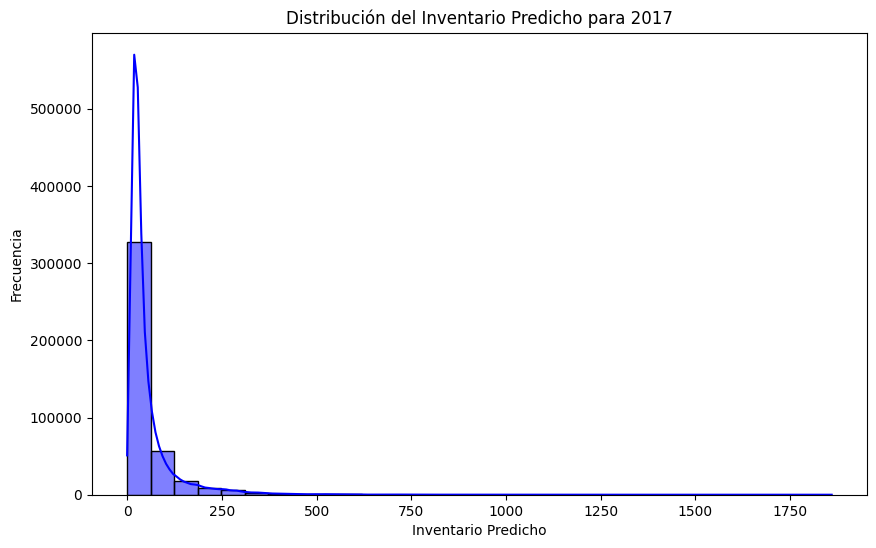

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(X_2017['predicted_stock_2017'], kde=True, bins=30, color='blue')
plt.title('Distribución del Inventario Predicho para 2017')
plt.xlabel('Inventario Predicho')
plt.ylabel('Frecuencia')
plt.show()


In [96]:
# Especificar las columnas que quieres incluir
output_data = X_2017[
    ['onHand_start', 'purchased_quantity', 'Price_start', 
     'inventory_duration_days','Brand', 'predicted_stock_2017']
]

# Exportar a un archivo Excel
output_file = 'predicted_stock_2017.xlsx'
output_data.to_excel(output_file, index=False)

print(f"Predicciones guardadas en el archivo: {output_file}")


Predicciones guardadas en el archivo: predicted_stock_2017.xlsx


In [94]:
print(X_2017.columns)



Index(['onHand_start', 'purchased_quantity', 'Price_start',
       'inventory_duration_days', 'Brand', 'predicted_stock_2017'],
      dtype='object')
